### Instalace potřebných modulů: ipython, numpy, pandas, sklearn

In [26]:
!pip -q install ipython ipywidgets numpy pandas scikit-learn matplotlib

### Načtení potřebných modulů

In [27]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt

### Načtení a zpracování dat

In [28]:
# Načte data ze soubor
try:
    # Nejdříve zkusí excel soubor
    DATA = pd.read_excel("data.xlsx")
except:
    # Poté zkusí csv soubor
    # Pokud hlásí chybu, je možné nastavit vlastní:
    # > delimiter ... oddělovač dat (čárka, středník)
    # > decimal ... oddělovač desetinných míst (čírka, tečka)
    DATA = pd.read_csv("data.csv", delimiter=",", decimal=",")
display(DATA)
# Odstraní první sloupeček
data = DATA.drop(DATA.columns[0], axis=1, inplace=False)
# Získá indexy řídků, kde chybí číslo v posledním sloupečku
indexy_pro_predikci = data.index[data[data.columns[-1]].isnull().values].tolist()
# Získá řádky, které se mohou použít pro regresi
data_pro_predikci = data.loc[indexy_pro_predikci].drop(data.columns[-1], axis=1, inplace=False)
data = data.loc[data.index.difference(indexy_pro_predikci)]
# Převedení dat do číselných polí
data_numbers = data.to_numpy()
vstup_pro_regresi = data_numbers[:,:-1]
vystup_pro_regresi = data_numbers[:,-1]
vstup_pro_predikci = data_pro_predikci.to_numpy()

,Projekt,m2,vzdálenost,počet modulů,počet vývozních dní,průměrná váha modulu,průměrná výška modulu,průměrná šířka modulu,průměrná délka modulu,cena kalkulovaná Euro,cena skutečná
0,Dueren,1500,600,43,3,20,3,3.5,14,150000,200000.0
1,Pirna II,1200,250,22,2,18,3,4.0,16,170000,155000.0
2,Ronnenberg,800,550,11,1,25,3,4.0,16,170000,190000.0
3,Ronnenberg,820,580,8,2,22,4,3.0,18,190000,NaN


### Výběr predikčního modelu

LinearRegression - **obyčejná** lineární regrese

Ridge - **vylepšená** lineární regrese, **sníží** vliv dimenzí, které by mohli rozhodit výsledek

Lasso - **vylepšená** lineární regrese, **vynuluje** vliv dimenzí, které by mohli rozhodit výsledek

In [29]:
if "vyber_modelu" not in globals():
    # Vytvoří radio tlačítka pro výběr predikčního modelu
    # Podmínka zabrání resetování výběru při novém spuštění
    vyber_modelu = ipywidgets.RadioButtons(
        options=["LinearRegression", "Ridge", "Lasso"],
        description="Model:"
    )
display(vyber_modelu)

RadioButtons(description='Model:', options=('LinearRegression', 'Ridge', 'Lasso'), value='LinearRegression')

### Vytvoření predikčního modelu pomocí lineární regrese

https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#linear-model-from-regression-to-sparsity

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [30]:
if vyber_modelu.value == "LinearRegression":
    regrese = linear_model.LinearRegression()
elif vyber_modelu.value == "Ridge":
    regrese = linear_model.Ridge(alpha=0.1)
elif vyber_modelu.value == "Lasso":
    regrese = linear_model.Lasso()
regrese.fit(vstup_pro_regresi, vystup_pro_regresi)

LinearRegression()

### Vypsání parametrů modelu

https://en.wikipedia.org/wiki/Coefficient_of_determination

https://scikit-learn.org/stable/modules/classes.html#regression-metrics

In [31]:
n, p = vstup_pro_regresi.shape
y_true = vystup_pro_regresi
y_pred = regrese.predict(vstup_pro_regresi)
R2 = metrics.r2_score(y_true, y_pred)
adjR2 = 1 - (1 - R2)*(n - 1)/(n - p)
# Výpis parametrů modelu
print("Lineární koeficienty:", [*regrese.coef_, regrese.intercept_])
print("Počet vstupních sloupců:", (regrese.rank_ if hasattr(regrese, "rank_") else None, regrese.n_features_in_))
print()
print("Koef. determinace  R2    ", round(R2, 6))
print("Adjustovaný        R2    ", round(adjR2, 6))
print("Max. chyba         e_max ", round(metrics.max_error(y_true, y_pred), 6))
print("Průměrná chyba     |e|   ", round(metrics.mean_absolute_error(y_true, y_pred), 6))
print("Středová chyba     |e|   ", round(metrics.median_absolute_error(y_true, y_pred), 6))
print("Průměrná chyba     e^2   ", round(metrics.mean_squared_error(y_true, y_pred), 6))

Lineární koeficienty: [-55.929259470886365, 42.01465674067706, -1.5365531924001918, -0.1397937086174281, 0.9796158024743624, 0.0, -5.888011957586796e-05, -0.00023552047830347183, -2.3552047830346226, 612012.7149728338]
Počet vstupních sloupců: (2, 9)

Koef. determinace  R2     1.0
Adjustovaný        R2     1.0
Max. chyba         e_max  0.0
Průměrná chyba     |e|    0.0
Středová chyba     |e|    0.0
Průměrná chyba     e^2    0.0


### Predikce

In [32]:
vysledek_predikce = regrese.predict(vstup_pro_predikci)

### Uložení predikovaných dat

In [33]:
DATA.loc[indexy_pro_predikci, DATA.columns[-1]] = vysledek_predikce
display(DATA)
DATA.to_excel("data_new.xlsx")

,Projekt,m2,vzdálenost,počet modulů,počet vývozních dní,průměrná váha modulu,průměrná výška modulu,průměrná šířka modulu,průměrná délka modulu,cena kalkulovaná Euro,cena skutečná
0,Dueren,1500,600,43,3,20,3,3.5,14,150000,200000.000000
1,Pirna II,1200,250,22,2,18,3,4.0,16,170000,155000.000000
2,Ronnenberg,800,550,11,1,25,3,4.0,16,170000,190000.000000
3,Ronnenberg,820,580,8,2,22,4,3.0,18,190000,143039.289458


### Vytvoření grafů

In [34]:
if "vyber_ticks" not in globals():
    # Vytvoří radio tlačítka pro výběr zobrazení čísel v grafech
    # Podmínka zabrání resetování výběru při novém spuštění
    vyber_ticks = ipywidgets.RadioButtons(
        options=["Ano", "Ne"],
        description="Zobrazit čísla ve grafech"
    )
display(vyber_ticks)

RadioButtons(description='Zobrazit čísla ve grafech', options=('Ano', 'Ne'), value='Ano')

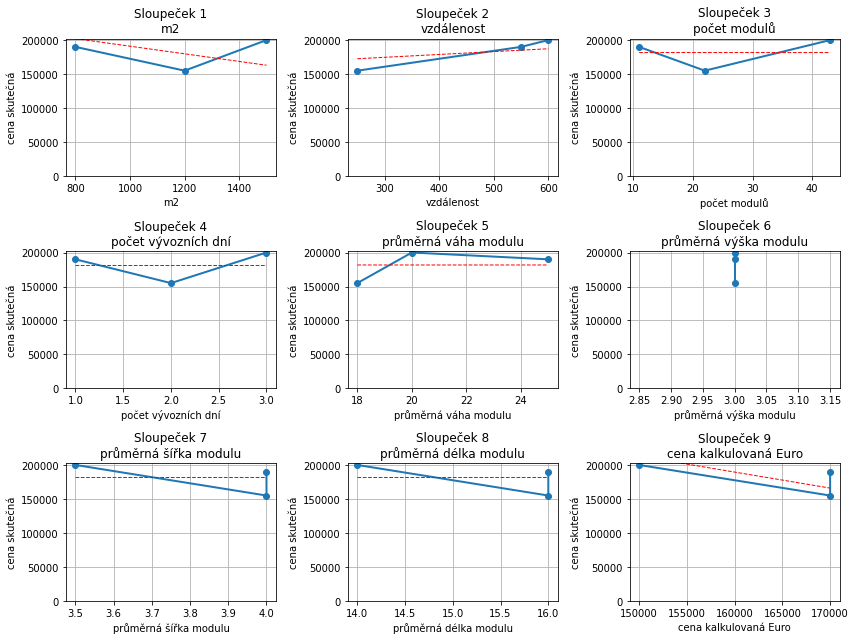

In [35]:
# Určí počet sloupců a řádků
N = vstup_pro_regresi.shape[1]
nx = 3
ny = int(N/nx + 0.5)
# Vytvoří podgrafy
fig, axes = plt.subplots(ncols=nx, nrows=ny, figsize=(4*nx, 3*ny))
# Projde všechny podgrafy a naplní je daty
for i, ax in zip(range(N), axes.flat):
    # Seřadí data
    serazene_data = zip(*sorted(zip(vstup_pro_regresi[:,i], vystup_pro_regresi)))
    # Vytvoří graf ze vstupních dat
    x = next(serazene_data)
    y = next(serazene_data)
    ax.plot(x, y, "-o", linewidth=2)
    ax.set_title(f"Sloupeček {i+1}\n{data.columns[i]}")
    ax.set_ylim(bottom=0)
    ax.set_xlabel(data.columns[i])
    ax.set_ylabel(data.columns[-1])
    ax.grid(True)
    # Vytvoří přibližnou reprezentaci lineárního modelu
    q = regrese.coef_[i]
    mx = np.mean(x)
    my = np.mean(y)
    k = my - q*mx
    y2 = [q*xi + k for xi in x]
    ax.plot(x, y2, "r--", linewidth=1)
    # Odstraní čísla na osách
    if vyber_ticks.value == "Ne":
        ax.tick_params(
            axis="both", which="both",
            bottom=False, top=False, left=False, right=False,
            labelbottom=False, labeltop=False,
            labelleft=False, labelright=False
        )
# Vymaže prázdné grafy
for i in range(N, len(axes.flat)):
    axes.flat[i].remove()
# Zobrazí vše
plt.tight_layout()
plt.show()